In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
examples_file_name = '/global/homes/v/vsharma2/TriProtonDecay/Simulation/Model/Input/TrainingExamples_25k.npy'
labels_file_name = '/global/homes/v/vsharma2/TriProtonDecay/Simulation/Model/Input/Labels_25k.npy'
x = np.load(examples_file_name)
y = np.load(labels_file_name)

In [3]:
xTrain, xVal, yTrain, yVal = train_test_split(x, y, test_size=0.2, random_state=169)

In [5]:
print('Training dataset -- ' + str(xTrain.shape))
print('Validation dataset -- ' + str(xVal.shape))
print('Training labels -- ' + str(yTrain.shape))
print('Validation labels -- ' + str(yVal.shape))

Training dataset -- (40000, 10, 10, 13)
Validation dataset -- (10000, 10, 10, 13)
Training labels -- (40000,)
Validation labels -- (10000,)


### Model notes
1) he initialization?

In [6]:
def get_model(width=10, height=10, depth=13):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=2, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    #x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    #x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=10, height=10, depth=13)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 10, 13, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 9, 9, 12, 64)      576       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 4, 6, 64)      0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 2, 4, 64)       110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 1, 2, 64)      0         
 3D)                                                             
                                                                 
 global_average_pooling3d (G  (None, 64)               0     

2023-10-12 07:19:15.157785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 07:19:16.842688: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [7]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "ppp_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    x=xTrain,
    y=yTrain,
    validation_data = (xVal, yVal),
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100


2023-10-12 07:19:45.216713: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-10-12 07:19:46.885199: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 - 12s - loss: 0.2515 - acc: 0.9371 - val_loss: 0.1264 - val_acc: 0.9637 - 12s/epoch - 10ms/step
Epoch 2/100
1250/1250 - 6s - loss: 0.1210 - acc: 0.9667 - val_loss: 0.1108 - val_acc: 0.9684 - 6s/epoch - 5ms/step
Epoch 3/100
1250/1250 - 7s - loss: 0.1121 - acc: 0.9698 - val_loss: 0.1039 - val_acc: 0.9705 - 7s/epoch - 5ms/step
Epoch 4/100
1250/1250 - 6s - loss: 0.1071 - acc: 0.9716 - val_loss: 0.1022 - val_acc: 0.9711 - 6s/epoch - 4ms/step
Epoch 5/100
1250/1250 - 5s - loss: 0.1026 - acc: 0.9725 - val_loss: 0.0983 - val_acc: 0.9712 - 5s/epoch - 4ms/step
Epoch 6/100
1250/1250 - 6s - loss: 0.0999 - acc: 0.9733 - val_loss: 0.0967 - val_acc: 0.9717 - 6s/epoch - 5ms/step
Epoch 7/100
1250/1250 - 6s - loss: 0.0971 - acc: 0.9736 - val_loss: 0.0971 - val_acc: 0.9723 - 6s/epoch - 4ms/step
Epoch 8/100
1250/1250 - 6s - loss: 0.0955 - acc: 0.9738 - val_loss: 0.0929 - val_acc: 0.9726 - 6s/epoch - 5ms/step
Epoch 9/100
1250/1250 - 6s - loss: 0.0925 - acc: 0.9742 - val_loss: 0.0919 - val_acc: 0.9

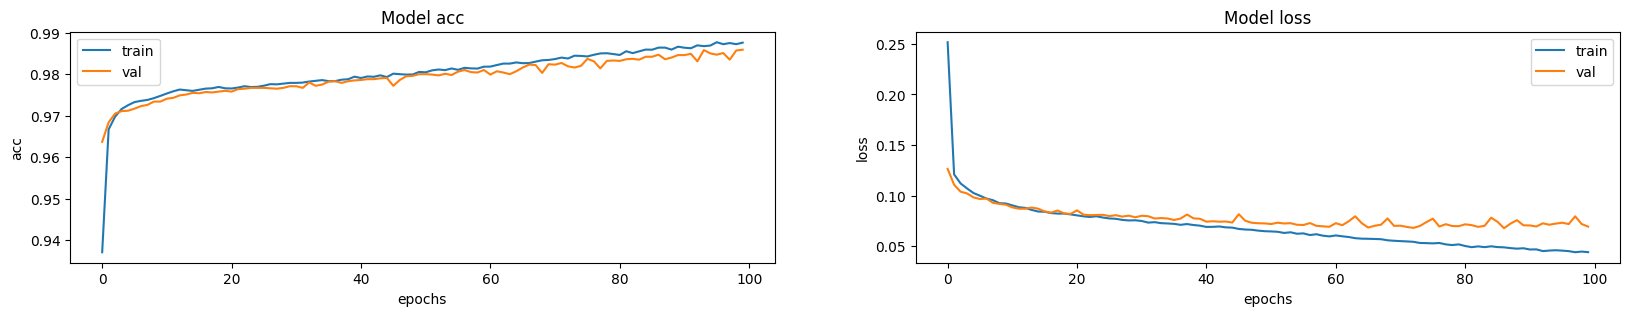

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [9]:
model2 = keras.models.load_model('/global/homes/v/vsharma2/TriProtonDecay/Simulation/Model/3d_image_classification.h5')

In [9]:
y_pred_probs = model.predict(xVal)

313/313 [==============================] - 1s 2ms/step


Text(0.5, 0, 'Prediction probability for ppp decay')

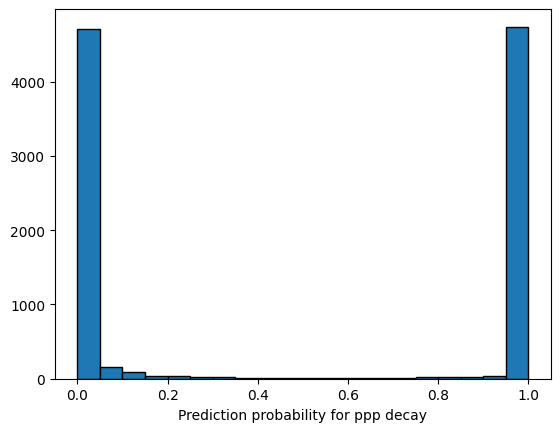

In [10]:
plt.hist(y_pred_probs, bins=20, edgecolor='black')
plt.xlabel('Prediction probability for ppp decay')

In [11]:
yPred = y_pred_probs > 0.5
yPred = yPred.astype(int)

In [12]:
yPred

array([[0],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

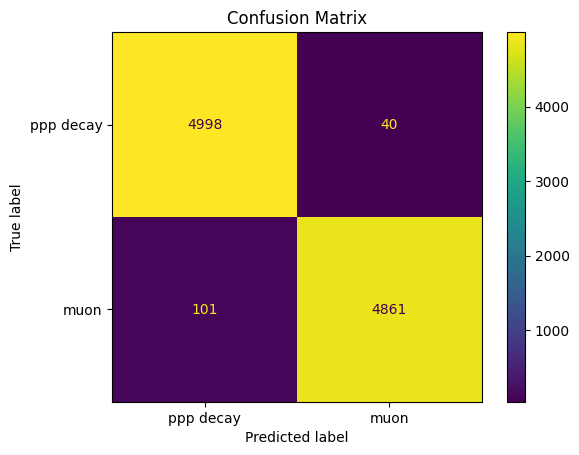

In [14]:
labels = ['ppp decay', 'muon']
cm = confusion_matrix(yVal, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=cmScaled, display_labels=labels)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'cmScaled' is not defined